# Data augmentation: how to draw several relevant samples  from one?

In this notebook, we will try to see how to use long-duration samples to generate shorter samples.

In [87]:
from pie_utils import *
import matplotlib.pyplot as plt
from librosa.effects import trim, split, time_stretch
import librosa.display as display
from IPython.display import Audio
import IPython.display

In [2]:
#The datapath depends on the configuration of your own folder PIE. Check your data path out !
#datapath = './' #directory where audio files are
datapath = "../../data_pie/" 

train = pd.read_csv(osp.join(datapath,"data-PIE-Sonar.csv"))

In [3]:
Y = train['label']
list_labels = train.label.unique()
list_labels.sort()

In [4]:
def parser_length(row,
                  data_directory_path,
                  trim=True,
                  db_cutoff=3):
    file_name = osp.join(data_directory_path, row['fname'])
    try:
        y, sr = librosa.load(file_name, res_type='kaiser_fast')
    except Exception as e:
        print('Error encountered while parsing the file:',file_name)
        print(e)
        return 'None'
    if(trim):
        y = librosa.effects.trim(y, top_db=db_cutoff)[0]
    return len(y)/sr

In [5]:
data_dir = osp.join(datapath,'audio_train')
data = train.assign(audio_length=train.apply(lambda x : parser_length(x,data_directory_path=data_dir,trim=True),axis=1))

### Example with different classes

In [120]:
print(list_labels)

['Acoustic_guitar' 'Applause' 'Bark' 'Bass_drum' 'Burping_or_eructation'
 'Bus' 'Cello' 'Chime' 'Clarinet' 'Computer_keyboard' 'Cough' 'Cowbell'
 'Double_bass' 'Drawer_open_or_close' 'Electric_piano' 'Fart'
 'Finger_snapping' 'Fireworks' 'Flute' 'Glockenspiel' 'Gong'
 'Gunshot_or_gunfire' 'Harmonica' 'Hi-hat' 'Keys_jangling' 'Knock'
 'Laughter' 'Meow' 'Microwave_oven' 'Oboe' 'Saxophone' 'Scissors'
 'Shatter' 'Snare_drum' 'Squeak' 'Tambourine' 'Tearing' 'Telephone'
 'Trumpet' 'Violin_or_fiddle' 'Writing']


Scissors: 30 / 59 instances > 2 seconds
Name of the file choosen randomly : 8680253f.wav


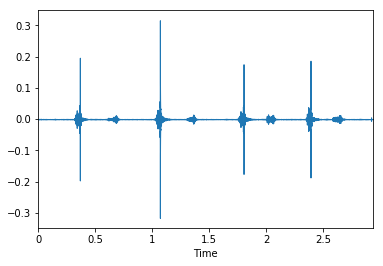

In [299]:
label = 'Scissors'
data_class = data[np.multiply(data['manually_verified']==1,data['label']==label)]
long_instances = data_class[data_class['audio_length']<1]
print(label,end=': ')
print('{} / {} instances > 2 seconds'.format(long_instances.shape[0],data_class.shape[0]))
fname = long_instances.sample(n=1)['fname'].values[0]
print('Name of the file choosen randomly : {}'.format(fname))
y, sr = librosa.load(osp.join(data_dir,fname), res_type='kaiser_fast')
display.waveplot(y,sr)
plt.show()
IPython.display.display(Audio(data=y,rate=sr))

y splitted into 6 samples


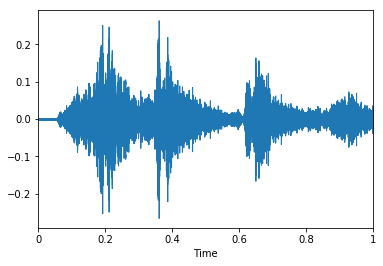

y splitted into 6 samples


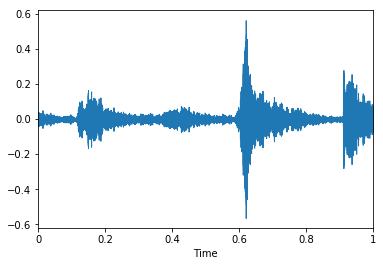

y splitted into 6 samples


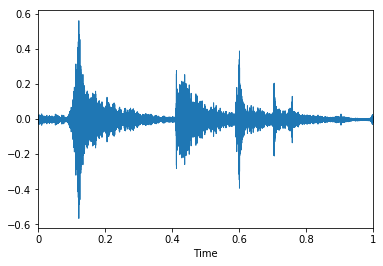

y splitted into 6 samples


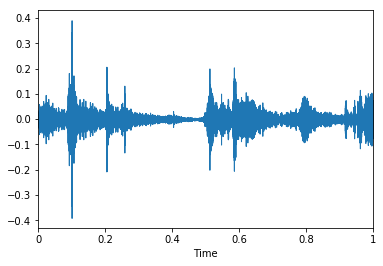

y splitted into 6 samples


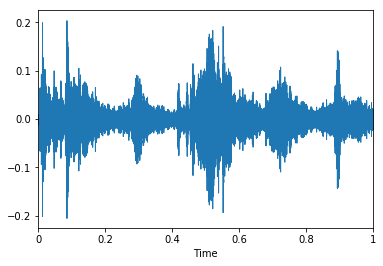

y splitted into 6 samples


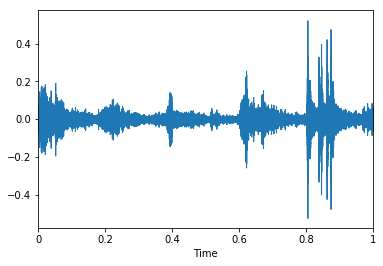

In [296]:
y_split = split_audio(y, sr, max_perc_flat=60)
for i in range(len(y_split)):
    y_sub = y_split[i]
#    flat = flats[i]
#    print('flatness of the sample (%): {}'.format(flat))
    print('y splitted into {} samples'.format(len(y_split)))
    display.waveplot(y_sub,sr)
    plt.show()
    IPython.display.display(Audio(data=y_sub,rate=sr))    

In [294]:
#the following function calculates the % of the audio samples extracted from y that are below y median level
def compute_flatness(y, l_y):
    l_flat = []
    for y_sub in l_y:
        l_flat.append(100 * len(np.where(y_sub**2 < np.median(y**2))[0]) / len(y_sub))
    return np.array(l_flat)

def split_audio(y, sr, 
                frame_duration=100e-2, 
                hop_duration=50e-2,
                db_cut=18,
                max_perc_flat=None):
    frame_length = int(frame_duration*sr)
    hop_length = int(hop_duration*sr)
    y_splitted = split(y,top_db=db_cut,frame_length=frame_length,hop_length=hop_length)
    nb_samples = y_splitted.shape[0]
    l_y = []
    if nb_samples == 1: #The sample wasn't splitted
        if len(y) > hop_length + frame_length: #then we chop applying sliding windows
            ind_start_frame = 0
            ind_end_frame = frame_length
            while ind_end_frame < len(y):              
                l_y.append(y[ind_start_frame : ind_end_frame])
                ind_start_frame += hop_length
                ind_end_frame += hop_length
        else: #the sample is too short to be chopped
            l_y.append(y)
    else: #the sample was splitted
        for i in range(nb_samples):
            l_y.append(y[y_splitted[i][0] : y_splitted[i][1]])
    l_y = np.array(l_y)
    if max_perc_flat is not None: #Then we filter the resulting list 
        l_flat = compute_flatness(y, l_y)
        return l_y[np.where(l_flat < max_perc_flat)[0]]
    else:
        return l_y

## How to use split for better predictions ?

Now that we have seen how to breakdown a train sample into several relevant samples, we would like to use it as well on test samples to provide better predictions. We will implement bellow a function that use majoritary vote on the samples drawn from the test sample to predict the result.

In [2]:
def predict_sample_split(y, sr, classifier, parser, nb_class=41, args_split=None, args_parser=None):
    l_votes = np.zeros(nb_class)
    if args_split is not None:
        l_y = split_audio(y, sr, **args_split)
    else:
        l_y = split_audio(y, sr)
    if args_parser is not None:
        pars = lambda x : parser(x, sr, **args_parser)
    else:
        pars = lambda x : parser(x, sr)
    feats = []
    for y in l_y:
        feats.append(pars(y))
    x = np.array(feats)
    prediction = classifier.predict(x)
    if np.shape(prediction)[1] > 1: #Ohe format
        l_votes = np.sum(prediction, axis=0)
    else: #Standard format
        for nb_label in prediction:
            l_votes[nb_label] += 1
    return l_vote

In [3]:
def predict_set_split(X, sr, classifier, parser, nb_class=41, args_split=None, args_parser=None):
    '''X_test must contain in its rows audio samples in librosa format'''
    nb_samples = X.shape[0]
    Y = np.zeros(nb_samples)
    for n in range(nb_samples):
        y = X[n]
        l_vote = predict_sample_split(y, sr, classifier, parser, nb_class=41, args_split=None, args_parser=None)
        Y[n] = np.random.choice(np.argmax(l_vote))
    return Y